# 注意力汇聚：Nadaraya-Watson 核回归



| 概念        | 角色        | 类比      | 在核回归中的具体含义                          |
| :-------- | :-------- | :------ | :---------------------------------- |
| **Query** | **提问者**   | 你想知道的问题 | 当前要预测的**测试点** `x_test`              |
| **Key**   | **索引/标签** | 知识库的目录  | **训练点的输入** `x_train`，用于计算与Query的相似度 |
| **Value** | **实际内容**  | 知识库的答案  | **训练点的输出** `y_train`，是最终被加权聚合的目标    |


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

生成数据集

In [2]:
n_train = 50 # 训练样本数量
# 生成50个[0,5)区间的随机数，并排序得到训练输入x_train,排序是为了让数据点沿x轴均匀分布，便于训练和可视化
x_train, _ = torch.sort(torch.rand(n_train) * 5)
'''
定义真实函数：f(x)=2sin(x)+x^0.8 
这是一个非线性函数，用于创建具有挑战性的回归任务
'''
def f(x):
    return 2 * torch.sin(x) + x**0.8
# 计算x_train对应的真实函数值,添加均值为0、标准差为0.5的高斯噪声，模拟真实世界的观测数据
y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
x_test = torch.arange(0, 5, 0.1) # 从0到4.9，步长0.1，共50个点
y_truth = f(x_test) # 测试集的真实函数值（无噪声）
n_test = len(x_test) # 测试样本数量（值为50）
n_test

50

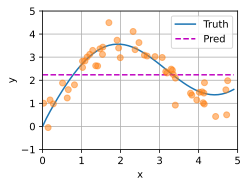

In [3]:
# 定义一个绘图函数，专门用于核回归结果的可视化,参数y_hat是模型对x_test的预测值
def plot_kernel_reg(y_hat):
    # 绘制两条曲线：蓝色线：真实函数y_truth=f(x_test)（无噪声）；橙色线：模型预测y_hat
    # 设置坐标轴标签、图例和显示范围
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    # 叠加训练数据点（散点图）：用圆圈标记，半透明（alpha=0.5），便于观察底层曲线
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);
'''
基准预测部分
创建均值预测（平均汇聚）：
y_train.mean()：计算训练输出的平均值（标量）
repeat_interleave(..., n_test)：将该均值重复50次（n_test）
结果：对所有测试点，预测值都是相同的常数
作用：这是一个最基础的baseline，完全忽略输入x，只输出训练数据的平均值
'''
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat) # 调用函数，可视化该基准模型的效果

非参数注意力汇聚
$\sum_{i=1}^{n}softmax(-\frac{1}{2}(x-x_{i})^2)y_{i}  $

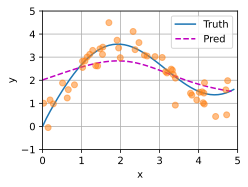

In [4]:
'''
1. 构造测试-训练点对矩阵
作用：将每个测试点与所有训练点配对，计算相似度
x_test形状: (n_test=50,)
repeat_interleave(n_train)→每个测试点重复50次:(2500,)
reshape((-1,n_train))→重塑为: (n_test,n_train)=(50,50)
结果：矩阵的每一行是对应测试点重复50次，便于后续广播计算与所有训练点的距离
'''
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
'''
2. 计算高斯核注意力权重
核心思想：距离越近，权重越大（高斯核函数）
计算步骤：
X_repeat-x_train：广播计算测试点与训练点的差值矩阵(50,50)
**2：平方差（欧氏距离的平方）
/ 2：高斯核的标准形式（带宽参数隐式设为1）
-：取负号，使距离越小，指数值越大
softmax(dim=1)：对每行归一化，得到注意力权重矩阵(50,50)
结果：attention_weights[i,j]表示第j个训练点对预测第i个测试点的重要性权重。
'''
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
'''
3. 加权平均预测
操作：矩阵乘法 (50,50)×(50,)→(50,)
含义：对每个测试点，用注意力权重对所有训练点的输出y_train做加权平均
公式：y_hat[i]=Σ_j attention_weights[i,j]*y_train[j]
'''
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

注意力权重

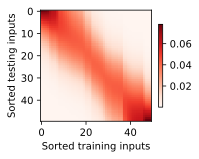

In [5]:
'''
1. 维度变换
attention_weights原始形状:(n_test,n_train)=(50,50)
第一个unsqueeze(0): 在最前面添加维度→(1,50,50);第二个unsqueeze(0): 再添加一个维度→(1,1,50,50)
目的：d2l.show_heatmaps期望输入形状为(batch_size,num_heads,seq_len,seq_len)
即：batch_size=1：单个样本批次;num_heads = 1：单注意力头（这里不是多头注意力）;seq_len=50：序列长度（测试点和训练点数量）
横轴(x-axis)：Sorted training inputs（排序后的训练输入x_train）
纵轴(y-axis)：Sorted testing inputs（排序后的测试输入x_test）
颜色深浅：注意力权重大小（越亮/越暖，权重越大）
'''
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

带参数注意力汇聚
假定两个张量的形状分别是$(n,a,b)$和$(n,b,c)$，
它们的批量矩阵乘法输出的形状为$(n,a,c)$<br>
$\sum_{i=1}^{n}softmax(-\frac{1}{2}((x-x_{i})w)^2)y_{i}  $

核心概念：bmm的维度要求

torch.bmm 要求：
- 批次维度必须相同：X 和 Y 的第一个维度必须相等（这里都是 2）
- 矩阵可乘：X 的最后一维必须等于 Y 的第二维（这里都是 4）

类比：想象有2个独立的矩阵乘法要并行计算：
第1个矩阵：X[0] (1×4) × Y[0] (4×6) → 结果 (1×6)<br>
第2个矩阵：X[1] (1×4) × Y[1] (1×6) → 结果 (1×6)

In [6]:
'''
# X: (2, 1, 4)  ×  Y: (2, 4, 6)
#      │  │  └───────┬──────┘  │
#      │  └───────────┼─────────┘
#      └──────────────┘
# 结果: (2, 1, 6)
'''
X = torch.ones((2, 1, 4)) # 形状:(批次数,行数,列数)=(2,1,4)
Y = torch.ones((2, 4, 6)) # 形状:(2,4,6)
# 规则：输出形状=(批次数,X的行数,Y的列数)
torch.bmm(X, Y).shape # 批量矩阵乘法后的输出形状

torch.Size([2, 1, 6])

使用小批量矩阵乘法来计算小批量数据中的加权平均值

| 张量        | 原始形状      | 变换操作             | 变换后形状            | 含义                 |
| :-------- | :-------- | :--------------- | :--------------- | :----------------- |
| `weights` | `(2, 10)` | `.unsqueeze(1)`  | **`(2, 1, 10)`** | 2个批次，每个是1行10列的权重向量 |
| `values`  | `(2, 10)` | `.unsqueeze(-1)` | **`(2, 10, 1)`** | 2个批次，每个是10行1列的值向量  |


torch.bmm 计算过程<br>
对每个批次独立进行矩阵乘法：<br>
批次 0：<br>
```python
weights[0] = [0.1, 0.1, ..., 0.1]  # (1, 10)
values[0] = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # (10, 1)
# 结果 = 0.1*0 + 0.1*1 + ... + 0.1*9 = 0.1 * 45 = 4.5
```
批次 1：<br>
```python
weights[1] = [0.1, 0.1, ..., 0.1]  # (1, 10)
values[1] = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]  # (10, 1)
# 结果 = 0.1*10 + 0.1*11 + ... + 0.1*19 = 0.1 * 145 = 14.5
```
最终输出<br>
```python
# 形状: (2, 1, 1)
tensor([[[ 4.5]],
        [[14.5]]])
```

In [7]:
'''
weights:注意力分数（对每个值的权重）
values:需要聚合的信息（如序列中每个位置的值）
bmm:计算weighted sum（加权平均），得到最终的上下文向量
'''
weights = torch.ones((2, 10)) * 0.1 # 形状:(2,10), 元素全为0.1
values = torch.arange(20.0).reshape((2, 10)) # 形状:(2,10)，数值为0-19
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1)) # 批量加权求和

tensor([[[ 4.5000]],

        [[14.5000]]])

带参数的注意力汇聚

| 操作               | 输入形状                  | 输出形状           | 数学意义                       |
| :--------------- | :-------------------- | :------------- | :------------------------- |
| `queries - keys` | `(50, 50) - (50, 50)` | `(50, 50)`     | **距离矩阵** `q_i - k_j`       |
| `* self.w`       | `(50, 50) * 标量`       | `(50, 50)`     | **可学习缩放**：`w·(q_i - k_j)`  |
| `**2 / 2`        | `(50, 50)`            | `(50, 50)`     | **高斯核**：`(q_i - k_j)² / 2` |
| `-(...)`         | `(50, 50)`            | `(50, 50)`     | **取负**：距离越小，值越大            |
| `softmax(dim=1)` | `(50, 50)`            | **`(50, 50)`** | **行归一化**：每行和为1             |


$attention\ weights_{ij} = \frac{\exp\left(-\frac{1}{2} \cdot (w \cdot (q_i - k_j))^2\right)}{\sum_{l=1}^{n_{{train}}} \exp\left(-\frac{1}{2} \cdot (w \cdot (q_i - k_l))^2\right)}$

| 张量                  | 变换前        | 变换操作             | 变换后               | 作用                 |
| :------------------ | :--------- | :--------------- | :---------------- | :----------------- |
| `attention_weights` | `(50, 50)` | `.unsqueeze(1)`  | **`(50, 1, 50)`** | 视为50个独立的`1×50`权重向量 |
| `values`            | `(50, 50)` | `.unsqueeze(-1)` | **`(50, 50, 1)`** | 视为50个独立的`50×1`值向量  |


$\hat{y}_i = \sum_{j=1}^{n_{train}} attention \ weights_{ij} \cdot v_j$

In [8]:
class NWKernelRegression(nn.Module):
    '''
    self.w：形状为(1,) 的可学习参数（标量），初始化为随机值
    在NWKernelRegression 模型中，self.w是唯一可学习的参数，它控制注意力分布的聚焦程度：
    w 值较大：放大测试点与训练点的距离差→注意力权重更集中在邻近点（尖锐分布）
    w 值较小：压缩距离差→注意力权重分布更宽泛（平滑分布）
    训练过程：通过反向传播，w会自动收敛到最优值（通常是一个正数），使模型对查询-键距离的缩放达到最佳，从而最小化预测误差
    '''
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        '''
        1. torch.rand((1,)):创建一个形状为 (1,)的张量（一个标量值）,初始值从均匀分布U[0,1)中随机采样
        2. nn.Parameter(...):与普通张量的核心区别：被nn.Parameter 包装的张量会自动被注册为模型参数
        自动行为：加入model.parameters()列表;梯度会自动计算和存储（.grad 属性）;会被优化器（如Adam）识别并更新
        3. requires_grad=True:显式启用梯度追踪,nn.Parameter默认就是requires_grad=True
        '''
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))
    '''
    前向传播
    参数约定（与Transformer注意力机制一致）：
    queries:查询向量（测试点），形状(batch_size,n_q)或(n_q,)
    keys:键向量（训练点），形状(batch_size,n_k)
    values:值向量（训练输出），形状(batch_size,n_k)
    '''
    def forward(self, queries, keys, values):
        '''
        步骤1：扩展查询以匹配键的形状:将queries从(n_q,)扩展为(n_q,n_k)，使其能与keys逐元素相减
        '''
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        '''
        步骤2：计算可学习的注意力权重
        (queries-keys)*self.w：距离乘以可学习参数w，动态调整核宽度
        非参数版本：-(queries-keys)**2/2（固定带宽=1）
        参数版本：w允许模型学习最优的注意力聚焦程度
        '''
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        '''
        步骤3：加权求和得到预测
        attention_weights.unsqueeze(1):(n_q,n_k)→(n_q,1,n_k)
        values.unsqueeze(-1):(n_q,n_k)→(n_q,n_k,1)
        torch.bmm(...):批量矩阵乘法，输出 (n_q,1,1)
        .reshape(-1):展平为 (n_q,)，返回每个查询点的预测值
        '''
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

将训练数据集变换为键和值

In [9]:
'''
留一法交叉验证 ：预测第 i 个训练点时， 排除自身，只用其他所有点作为"训练集"
将一维训练数据复制成50行的方阵，每行都是完整的训练集
重复参数: (行数, 列数)
keys[i]：第i个点预测时，其他点的 输入（x值）
values[i]：第i个点预测时，其他点的 输出（y值）
为什么？避免模型在训练时"偷看"答案，获得更真实的泛化误差评估
'''
X_tile = x_train.repeat((n_train, 1))
Y_tile = y_train.repeat((n_train, 1))
'''
步骤1：创建"移除对角线"的掩码
torch.eye(3)：单位矩阵
1-torch.eye(3)：对角线变0，其余变1
.type(torch.bool)：转为布尔类型→True表示保留，False表示丢弃
步骤2：应用掩码并重塑
X_tile[mask]：只保留mask中为True的位置
第0行：保留第1、2列→[0.5,0.9]
第1行：保留第0、2列→[0.1,0.9]
第2行：保留第0、1列→[0.1,0.5]
返回：展平的一维张量[0.5,0.9,0.1,0.9,0.1,0.5]（共6个元素）
.reshape((3, -1))：重塑为3行，列数自动推断
'''
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

训练带参数的注意力汇聚模型

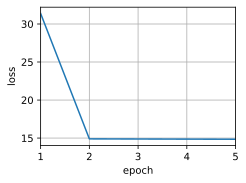

In [10]:
net = NWKernelRegression() # 实例化模型（含可学习参数w）
loss = nn.MSELoss(reduction='none') # 均方损失，保留每个样本的损失值（不聚合）
trainer = torch.optim.SGD(net.parameters(), lr=0.5) # SGD优化器，学习率0.5
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5]) # 动态绘制损失曲线

for epoch in range(5):
    trainer.zero_grad() # 清空梯度（防止累积）
    # 前向传播：用留一法的keys/values预测训练集y_train
    l = loss(net(x_train, keys, values), y_train) # l形状: (50,)
    l.sum().backward() # 反向传播：计算总损失的梯度
    trainer.step() # 更新参数：优化器根据梯度调整self.w
    # 打印与可视化
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

预测结果绘制

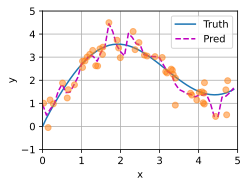

In [11]:
'''
作用：将训练数据复制n_test次，为每个测试点提供相同的参考数据
keys：每行都是完整的x_train，用于计算与测试点的距离
values：每行都是完整的y_train，用于加权平均得到预测值
类比：为每个测试点准备一份"训练数据手册"，供模型查询
'''
keys = x_train.repeat((n_test, 1)) # 形状: (n_test, n_train)
values = y_train.repeat((n_test, 1)) # 形状: (n_test, n_train)
'''
预测与后处理
net(x_test,keys,values):前向传播
输入：x_test(50个测试点),keys/values(50×50的重复矩阵)
输出：形状(n_test,)，每个测试点的预测值
.unsqueeze(1):增加第1维→形状(n_test,1)，匹配绘图函数要求的输入格式
.detach():从计算图中分离，停止梯度追踪（推理阶段不需要反向传播）
'''
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

曲线在注意力权重较大的区域变得更不平滑

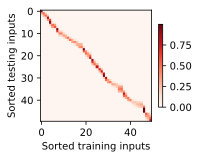

In [12]:
'''
横轴：排序后的训练输入（x_train的50个点）
纵轴：排序后的测试输入（x_test的50个点）
颜色深浅：注意力权重值（越亮表示关注度越高）
预期模式：
对角线附近亮：每个测试点主要关注邻近的训练点
离对角线越远越暗：距离远的训练点关注度指数衰减
注意力宽度：由学习到的参数w控制（w越大，聚焦越窄）
net.attention_weights  # 形状:(n_test=50,n_train=50)
这是模型在最后一次前向传播（对x_test预测）时计算的注意力权重
目的：匹配d2l.show_heatmaps要求的输入格式：
第0维：batch_size=1（单个样本）
第1维：num_heads=1（单注意力头）
第2、3维：seq_len=50（序列长度，即测试点和训练点数量）
'''
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0), # 增加两个维度→(1,1,50,50)
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')